In [1]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# Inital data
strikes = [95, 96, 97, 98, 99, 100, 101, 102, 103, 104]
prices = [10.93, 9.55, 8.28, 7.40, 6.86, 6.58, 6.52, 6.49, 6.47, 6.46]
risk_free_rate = 0.002
spot = 100


## Black-Scholes price

In [2]:
# Black-Scholes price function
#
# Returns a dictionary containing the price and the greeks of the option
def BS_price(spot, strike, time_to_maturity, r, vol):
    d1 = (np.log(spot / strike) + (r + vol**2 / 2) * (time_to_maturity)) / (vol * np.sqrt(time_to_maturity))
    d2 = d1 - vol * np.sqrt(time_to_maturity)

    price = spot * norm.cdf(d1) - strike * np.exp(-r * time_to_maturity) * norm.cdf(d2)
    delta = norm.cdf(d1)
    gamma = norm.pdf(d1) / (vol * spot * np.sqrt(time_to_maturity))
    vega = spot * np.sqrt(time_to_maturity) * norm.pdf(d1) 
    theta = -spot * norm.pdf(d1) * vol / (2 * np.sqrt(time_to_maturity)) - r * strike * np.exp(-r * time_to_maturity) * norm.cdf(d2) 
    dual_delta = - np.exp(-r * time_to_maturity) * norm.cdf(d2)
    dual_gamma = -np.exp(-r * time_to_maturity) * norm.pdf(d2) / (strike * vol * np.sqrt(time_to_maturity))

    option_parameters = {'price': price, 'delta': delta, 'gamma': gamma, 'vega': vega, 'theta': theta, 'dual delta': dual_delta, 'dual gamma': dual_gamma}

    return option_parameters

# Test:
test_option_par = BS_price(100, 110, 1, 0, 0.2)
print(f'Price: { test_option_par["price"] }') # Should be $4.29
print(f'Delta: { test_option_par["delta"] }') # Should be 0.353
print(f'Gamma: { test_option_par["gamma"] }') # Should be 0.019
print(f'Vega: { test_option_par["vega"] }')   # Should be 37.164
print(f'Theta: { test_option_par["theta"] }')  # Should be -3.716
print(f'Dual Delta: { test_option_par["dual delta"] }') # Should be -0.282
print(f'Dual Gamma: { test_option_par["dual gamma"] }') # Should be -0.015



Price: 4.292010941409885
Delta: 0.35325369152806296
Gamma: 0.018581922182971666
Vega: 37.16384436594333
Theta: -3.7163844365943337
Dual Delta: -0.2821214382854219
Dual Gamma: -0.015356960481794767


## Implied volatility from BS price

In [3]:
# Return the implied volatility using Newton-Raphson algorithm
def get_implied_vol(spot, strike, time_to_maturity, r, starting_vol, market_price):
    old_vol = 0
    new_vol = starting_vol
    while abs(old_vol - new_vol) > 1E-6:
        old_vol = new_vol
        opt_parameters = BS_price(spot, strike, time_to_maturity, r, old_vol)
        new_vol = old_vol - (opt_parameters["price"] - market_price) / opt_parameters["vega"]
    return new_vol

# Test:
test_implied_vol = get_implied_vol(100, 110, 1, 0.002, 0.2, 6.00)
print(f'Implied volatility: {test_implied_vol}')
test_option_par = BS_price(100, 110, 1, 0.002, test_implied_vol)
print(f'BS price using implied vol: {test_option_par["price"]}   Actual price: 6.00')

Implied volatility: 0.24331750447957207
BS price using implied vol: 6.0000000000003055   Actual price: 6.00


## Implied volatility smile

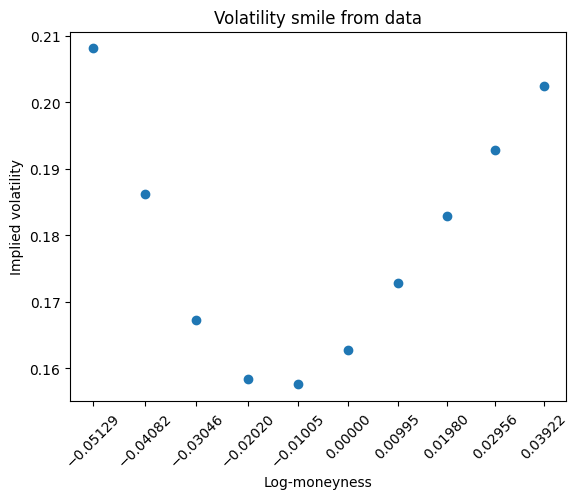

In [4]:
log_moneyness = [np.log(k / spot) for k in strikes]

# Compute the implied volatilities
implied_volatilites = []
for i in range(len(prices)):
    implied_volatilites.append(get_implied_vol(spot, strikes[i], 1, risk_free_rate, 0.2, prices[i]))

# Plot the results
fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Volatility smile from data")
ax.set_xticks(log_moneyness)
ax.tick_params(axis='x', rotation=45)
ax.scatter(log_moneyness, implied_volatilites)
plt.show()

## Estimation of the SVI

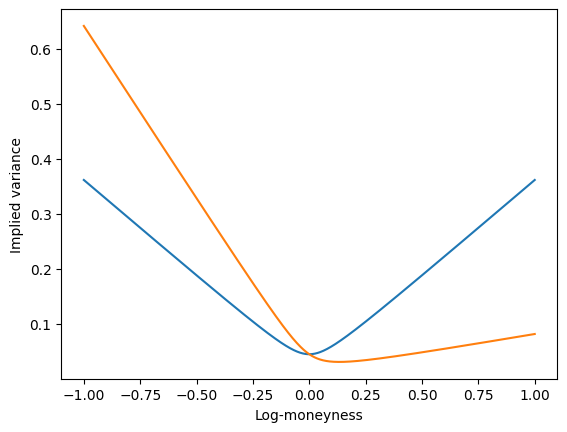

In [13]:
# Definition of the Stochastic Volatility Inspired (SVI) formula
def SVI_func(values, par):
    if isinstance(values, list):
        value = []
        for x in values:
            v = par["a"] + par["b"] * (par["rho"] * (x - par["m"]) + np.sqrt((x - par["m"])**2 + par["sigma"]**2))
            value.append(v)
    else:
        value = par["a"] + par["b"] * (par["rho"] * (values - par["m"]) + np.sqrt((values - par["m"])**2 + par["sigma"]**2))
    return value

# Definition of the generalized Stochastic Volatility Inspired (gSVI) formula
def gSVI_func(values, par):
    if isinstance(values, list):
        value = []
        for x in values:
            z = x / par["beta"]**(abs(x - par["m"]))
            v = par["a"] + par["b"] * (par["rho"] * (z - par["m"]) + np.sqrt((z - par["m"])**2 + par["sigma"]**2))
            value.append(v)
    else:
        z = values / par["beta"]**(abs(values - par["m"]))
        value = par["a"] + par["b"] * (par["rho"] * (z - par["m"]) + np.sqrt((z - par["m"])**2 + par["sigma"]**2))
    return value

# Test
fig, ax = plt.subplots()
x_axis = np.linspace(-1, 1, 1000)

# Different combinations of parameters
pars = {'a': 0.01, 'b': 0.35, 'rho': 0, 'm': 0, 'sigma': 0.1}
pars2 = {'a': 0.01, 'b': 0.35, 'rho': -0.8, 'm': 0, 'sigma': 0.1}

# Computation in two different ways to test the
# behaviour of the function
svi1 = []
for n in x_axis:
    svi1.append(SVI_func(n, pars)) 
svi2 = SVI_func(x_axis, pars2) 

ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied variance")
ax.plot(x_axis, svi1)
ax.plot(x_axis, svi2)

plt.show()

## Simulated Annealing

In [14]:
# Only used for uniform RNG
import random

def simulated_annealing(func, x_data, y_data, initial_T, max_iterations):
    # Generate the initial state and compute the initial energy
    if func is SVI_func:
        new_parameters = {'a': 0., 'b': 0.1, 'rho': 0.1, 'm': 0., 'sigma': 0.}
    elif func is gSVI_func:
        new_parameters = {'a': 0., 'b': 0.1, 'rho': 0.1, 'm': 0., 'sigma': 0., 'beta': 1.1}
    
    previous_energy = compute_energy_with_distortion(func, x_data, new_parameters, y_data, 20)

    optimal_parameters = new_parameters.copy()
    iter = 1
    T = initial_T

    # While we are above the minimum temperature
    while iter < max_iterations:

        # Generate a new state randomly
        if func is SVI_func:
            n = random.randint(1, 5)
        elif func is gSVI_func:
            n = random.randint(1, 6)

        if n == 1:
            # Change b
            if iter > max_iterations / 2:
                new_parameters["b"] = optimal_parameters["b"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["b"] = random.uniform(0.75, 0.85)
        elif n == 2:
            # Change rho
            if iter > max_iterations / 2:
                new_parameters["rho"] = optimal_parameters["rho"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["rho"] = random.uniform(-0.5, -0.35)
        elif n == 3:
            # Change m
            if iter > max_iterations / 2:
                new_parameters["m"] = optimal_parameters["m"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["m"] = random.uniform(-0.05, 0.05)
        elif n == 4:
            # Change sigma
            if iter > max_iterations / 2:
                new_parameters["sigma"] = optimal_parameters["sigma"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["sigma"] = random.uniform(-0.05, 0.05)
        elif n == 5:
            # Change a
            if iter > max_iterations / 2:
                new_parameters["a"] = optimal_parameters["a"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["a"] = random.uniform(-0.05, 0.05)
        elif n == 6:
            # Change beta
            if iter > max_iterations / 2:
                new_parameters["beta"] = optimal_parameters["beta"] + random.uniform(-T * 100, T * 100)
            else:
                new_parameters["beta"] = random.uniform(1., 1.4)

        # Compute the energy of the new state
        new_energy = compute_energy_with_distortion(func, x_data, new_parameters, y_data, 20)
        delta_energy = new_energy - previous_energy

        # If the new state has a lower energy than the previous one, save it
        if acceptance_function(T, delta_energy):
            optimal_parameters = new_parameters.copy()
            previous_energy = new_energy
            print(f'Iteration: {iter}  |  Best Energy: {pow(previous_energy, 20):.3}  |  Temperature: {T:.3e}', end="\r")

        # Reduce the temperature and increment iteration
        T = initial_T / iter
        iter += 1

    return optimal_parameters

# Computes the energy of the state. In this case the energy function
# (the function that should be minimized) is the sum of squared errors
def compute_energy_with_distortion(func, x_data, parameters, y_data, beta):
    estimate = func(x_data, parameters)
    energy = sum_of_err_squares(y_data, estimate)
    distorted_energy = pow(energy, 1/beta)
    return distorted_energy

# This function decides if the new state should be accepted or refuted
# according to simulated annealing decision rule
def acceptance_function(T, delta_energy):
    if delta_energy < 0:
        return True
    else:
        r = random.uniform(0, 1)

        if T < 1E-6:
            return False

        if r < np.exp(-delta_energy / T):
            return True
        else:
            return False

# Returns the sum of the squared errors
def sum_of_err_squares(true_data, estimated_data):
    diff = [(elem1 - elem2)**2 for elem1, elem2 in zip(true_data, estimated_data)]
    s = sum(diff)
    return s

{'a': 0.007386432463786766, 'b': 0.7915126134339514, 'rho': -0.40739195226558206, 'm': -0.025608667490057614, 'sigma': -0.02373182052187722}
Final energy: 1.7763666123815703e-07
Final energy (generalized): 1.7581385490999647e-07


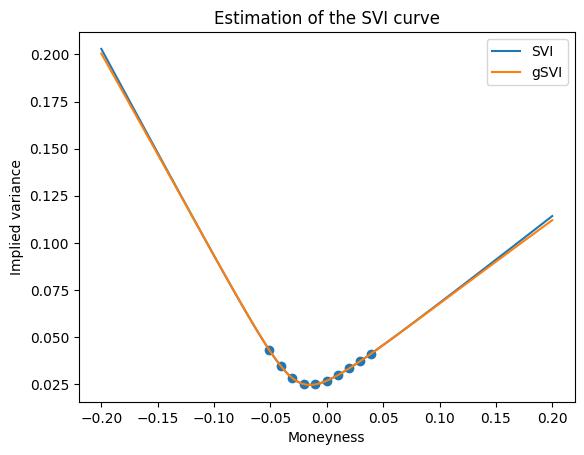

In [ ]:
def compute_energy(func, x_data, parameters, y_data):
    estimate = func(x_data, parameters)
    return sum_of_err_squares(y_data, estimate)

# Fit the implied variance which is more regular, to get the volatilities
# then just do sqrt(implied_variance)
implied_variance = [v**2 for v in implied_volatilites]

# If set to True it runs the optimization algorithm, if set to False
# use the optimal parameters found previously 
if False:
    best_par = simulated_annealing(SVI_func, log_moneyness, implied_variance, 10, 2E6)
    generalized_best_par = simulated_annealing(gSVI_func, log_moneyness, implied_variance, 10, 2E6)
else:
    best_par = {'a': 0.007386432463786766, 'b': 0.7915126134339514, 'rho': -0.40739195226558206, 'm': -0.025608667490057614, 'sigma': -0.02373182052187722}
    generalized_best_par = {'a': 0.00652490563018189, 'b': 0.8134782389338896, 'rho': -0.41070426262973697, 'm': -0.02592370814631364, 'sigma': 0.024283975676713476, 'beta': 1.2028620109261117}

# Print and plot the results
print(best_par)
print(f'Final energy: {compute_energy(SVI_func, log_moneyness, best_par, implied_variance)}')
print(f'Final energy (generalized): {compute_energy(gSVI_func, log_moneyness, generalized_best_par, implied_variance)}')

x_axis = np.linspace(-0.2, 0.2, 100)

fig, ax = plt.subplots()
ax.set_title("Estimation of the SVI curve")
ax.set_xlabel("Moneyness")
ax.set_ylabel("Implied variance")
ax.plot(x_axis, SVI_func(x_axis, best_par))
ax.plot(x_axis, gSVI_func(x_axis, generalized_best_par))
ax.scatter(log_moneyness, implied_variance)
ax.legend(["SVI", "gSVI"])
plt.show()

## Dupire's formula

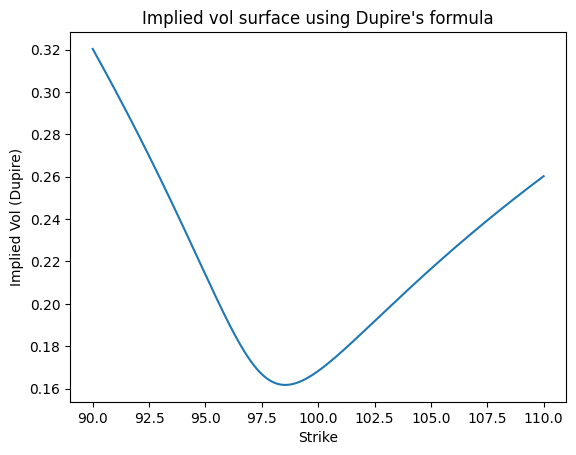

In [ ]:
def Dupire_vol(strike, r, theta, dual_delta, dual_gamma):
    num = 2 * (theta + r * strike * dual_delta)
    den = strike**2 * dual_gamma
    return num / den

# Create the strike grid
strike_grid = [90 + i * 0.01 for i in range(0, 2001)]
SVI_implied_vols = [np.sqrt(SVI_func(np.log(k / spot), best_par)) for k in strike_grid]

# Compute the Dupire's volatilities
dupire_vols = []
for i in range(len(strike_grid)):
    opt_par = BS_price(spot, strike_grid[i], 1, risk_free_rate, SVI_implied_vols[i])
    vol = Dupire_vol(strike_grid[i], risk_free_rate, opt_par["theta"], opt_par["dual delta"], opt_par["dual gamma"])
    dupire_vols.append(vol)

# Plot the results
fig, ax = plt.subplots()
ax.set_title("Implied vol surface using Dupire's formula")
ax.set_xlabel("Strike")
ax.set_ylabel("Implied Vol (Dupire)")
ax.plot(strike_grid, np.sqrt(dupire_vols))
plt.show()

## Model Calibration

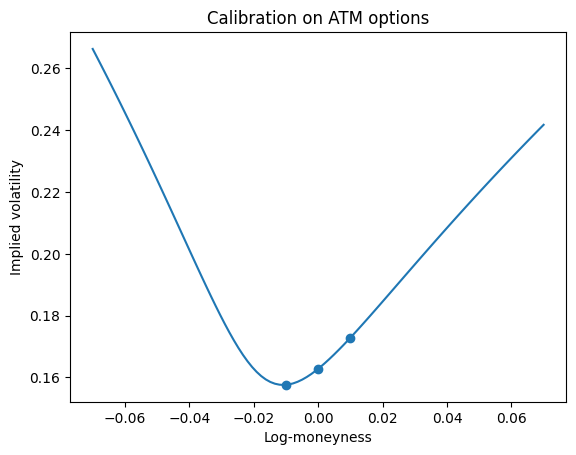

In [30]:
at_the_money_strikes = strikes[4:7]
at_the_money_prices = prices[4:7]
at_the_money_variance = implied_variance[4:7]

log_moneyness = [np.log(k / spot) for k in at_the_money_strikes]

# Calibrate the model only on the three options with closest strike to spot
if False:
    calibrated_par = simulated_annealing(SVI_func, log_moneyness, at_the_money_variance, 10, 2E6)
else:
    calibrated_par = {'a': 0.010264046888319656, 'b': 0.821871732953936, 'rho': -0.35733861978688597, 'm': -0.018090747458748817, 'sigma': -0.018967045336479162}

# Plot the results
x_axis = np.linspace(-0.07, 0.07, 100)

fig, ax = plt.subplots()
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Implied volatility")
ax.set_title("Calibration on ATM options")
ax.plot(x_axis, np.sqrt(SVI_func(x_axis, calibrated_par)))
ax.scatter(log_moneyness, np.sqrt(at_the_money_variance))
plt.show()